# VGG-16 Work

### Importing Libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

### Read the Data

In [16]:
# Translation dictionary for class labels
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "dog": "cane", "cavallo": "horse", "elephant": "elefante",
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
    "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

In [17]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [18]:
# Directories
directory = r'csv/raw-img'

# Data augmentation and generators
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(directory,  
                                                target_size=(224, 224), 
                                                batch_size=32,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(directory,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [19]:
# Translate and display class labels
class_labels = list(train_generator.class_indices.keys())

translated_labels = [translate.get(label, label) for label in class_labels]

print(f"Original Class labels: {class_labels}")
print(f"Translated Class Labels: {translated_labels}")


Original Class labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Translated Class Labels: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'ragno', 'squirrel']


### Show Number of Classes

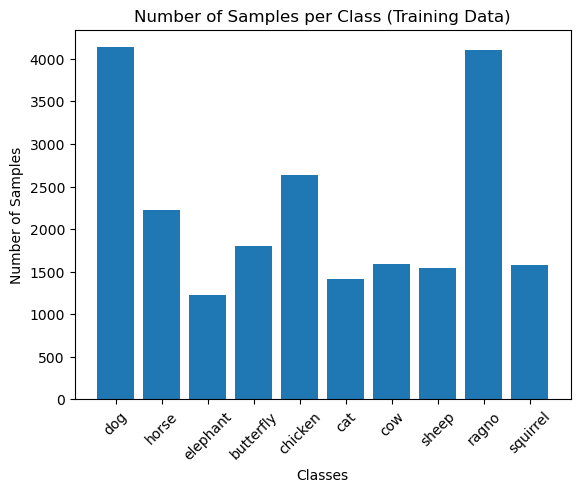

In [20]:
train_class_counts = np.bincount(train_generator.classes)
x = np.arange(len(translated_labels))
plt.bar(x, train_class_counts)
plt.xticks(x, translated_labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Class (Training Data)")
plt.show()

### Building VGG Model

In [ ]:
# Define the input dimensions
img_height, img_width = 224, 224 

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [22]:
# Add custom layers on top of the VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector per image
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(10, activation='softmax')(x)  # Final output layer for 10 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy", "Precision", "Recall"]
)

In [28]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('vgg16.keras', save_best_only=True)
]

In [ ]:
# Training
history = model.fit(train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=callbacks)

Epoch 1/5
  5/696 [..............................] - ETA: 29:48 - loss: 2.2491 - accuracy: 0.1813 - precision: 0.0000e+00 - recall: 0.0000e+00

In [ ]:
def plot_training_history(history, metrics, title="Training and Validation Metrics", save_path=None):
    valid_metrics = [metric for metric in metrics if metric in history.history]
    num_metrics = len(valid_metrics)
    rows = (num_metrics + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axs = axs.flatten()

    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axs, valid_metrics):
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue', linestyle='-', marker='o')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color='orange', linestyle='--', marker='x')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training vs. Validation {metric.capitalize()}')
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)

    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

metrics = ['accuracy', 'loss', 'recall', 'precision']

In [ ]:
plot_training_history(history, metrics)

In [ ]:
y_test = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)
print(classification_report(y_test, y_pred, target_names=translated_labels))

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=translated_labels, yticklabels=translated_labels)
plt.show()